In [63]:
from pylab import *

from casadi import *
import time
# Required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt




In [64]:
normalization = 1e9
δ  = 0.02
α  = 0.045007414
κ  = 2.094215255
pf = 20.76
ζ  = 1.66e-4 * normalization 
p1 =  38.29
p2 =  44.75

In [65]:
#Probability Matrix
from scipy.linalg import logm, expm
dτ=1/12
P = np.matrix([[0.984, 0.016],[0.035, 0.965]]) 
M = logm(P)/dτ
m1 = M[0,1]
m2 = M[1,0]

In [66]:
#Site Data
df = pd.read_csv("data/calibration_25SitesModel.csv")
z0_list = df['z_2017_25Sites'].to_numpy()
γ_list  = np.array([516.02993345, 488.49808684, 412.33930949, 610.50941424,
       658.45330829, 592.16877206, 537.94448328, 494.59293383,
       477.150307  , 339.73463789, 398.53061589, 214.64004431,
       629.09468404, 602.78528289, 530.96057575, 429.06875196,
        87.7872593 , 293.83458315, 776.20168882, 325.71253854,
       327.10909521, 368.99247031, 361.7819838 , 301.54938771,
       257.16349234])
x0_list = γ_list *df['forestArea_2017_ha_25Sites'].to_numpy()
θ_list  = df['theta_25Sites'].to_numpy()

Z0_list = z0_list/ normalization
X0_list = x0_list/ normalization

z̄ = (df['zbar_2017_25Sites'].to_numpy() )/normalization
n = len(z̄)

In [67]:
#Construct Matrix A
Az = np.zeros((n, n+2))
Ax = np.zeros((1, n+2-0))

Ax[0,0:n-0] = -α *γ_list[0:n]
Ax[0, -1] = np.sum(α*γ_list[0:n] * z̄[0:n])
Ax[0,-2]  = -α

A  = np.concatenate((Az, Ax, np.zeros((1, n+2-0))), axis=0)

In [68]:
# Construct Matrix B
Bz = np.identity((n-0))
Bx = (np.zeros((1,n-0)))

B  = np.concatenate((Bz, Bx,  np.zeros((1, n-0))), axis=0)

In [69]:
# Construct Matrix B
Dz =   np.zeros((n-0,n-0))
Dx = -(np.ones((1,n-0))*γ_list[0:n])

D  = np.concatenate((Dz, Dx, np.zeros((1, n-0))), axis=0)

In [70]:
T   = 200
N   = T

dt = T/N
Y = MX.sym('Y',n+2-0) 
up = MX.sym('up',n-0) 
um = MX.sym('um',n-0) 

rhs = (sparsify(A)@Y + sparsify(B)@(up-um) + sparsify(D)@(up))*dt + Y
f = Function('f', [Y, um, up],[rhs])


import math
ds_vect = np.zeros((N+1,1))
for i in range(N+1):
    ds_vect[i]=math.exp(-δ*i*dt)
    
P= expm(M*dt)


In [71]:
opti = casadi.Opti()

# Decision variables for states

X = opti.variable(n+2-0 ,N+1)
# Aliases for states

Up = opti.variable(n-0,N)
Um = opti.variable(n-0,N)
Ua = opti.variable(1,N)
# 1.2: Parameter for initial state
ic = opti.parameter(n+2-0)

# Gap-closing shooting constraints
for k in range(N):
    opti.subject_to(X[:,k+1]==f(X[:,k],Um[:,k], Up[:,k]))
    
# Initial and terminal constraints
opti.subject_to(X[:,0] == ic)
opti.subject_to(opti.bounded(0,X[0:n-0,:],z̄[0:n]))
# Objective: regularization of controls
# 1.1: added regularization
for k in range(n-0):
    opti.subject_to(opti.bounded(0,Um[k,:],inf))
    opti.subject_to(opti.bounded(0,Up[k,:],inf))

opti.subject_to(Ua == sum1(Up+Um)**2 )

opti.minimize( sum2(ds_vect[0:N,:].T*(Ua* ζ/2 ))
              - sum2(ds_vect[0:N,:].T*(pf*X[-2,1:] - pf*X[-2,0:-1]  ))
              - sum2(ds_vect.T*sum1((p2*θ_list - pf*κ )*X[0:n-0,:] )))




In [72]:
# solve optimization problem 
options = dict()
options["print_time"] = False
options["expand"]     = True
options["ipopt"]      = {
                    'print_level': 5,
                    'fast_step_computation':            'yes',
                    'mu_allow_fast_monotone_decrease':  'yes',
                    'warm_start_init_point':            'yes',
                        }
opti.solver('ipopt',options)

t1 = time.time()
opti.set_value(ic,vertcat(Z0_list,np.sum(X0_list),1))
sol = opti.solve()
disp(f'Initial, time: {time.time()-t1}')


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    41227
Number of nonzeros in inequality constraint Jacobian.:    15025
Number of nonzeros in Lagrangian Hessian.............:   255000

Total number of variables............................:    15627
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     5627
Total number of inequality constraints...............:    15025
        inequality constraints with only lower bounds:    10000
   inequality constraints with lower and upper bounds:     5025
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.55e+02 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [73]:
np.save('gamma_u_0.05',sol.value(X))

In [74]:
x_theta=np.load('theta_u_0.05.npy')
x_gamma=np.load('gamma_u_0.05.npy')

x_no_u = np.load('no_u.npy')

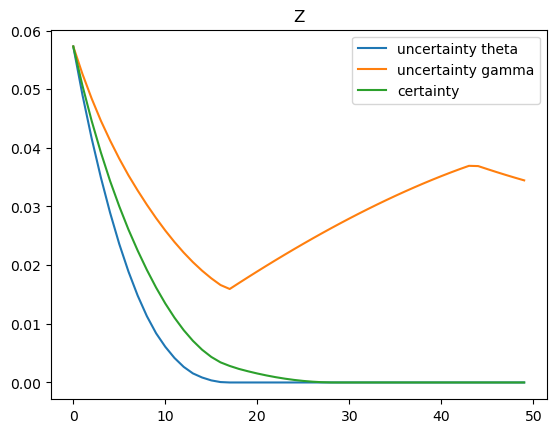

In [75]:
    plt.plot(np.sum(x_theta[0:n,0:50].T, axis = 1))
    plt.plot(np.sum(x_gamma[0:n,0:50].T, axis = 1))

    plt.plot(np.sum(x_no_u[0:n,0:50].T, axis = 1))
    plt.legend(['uncertainty theta','uncertainty gamma','certainty'])
    plt.title(f'Z')
    plt.show()

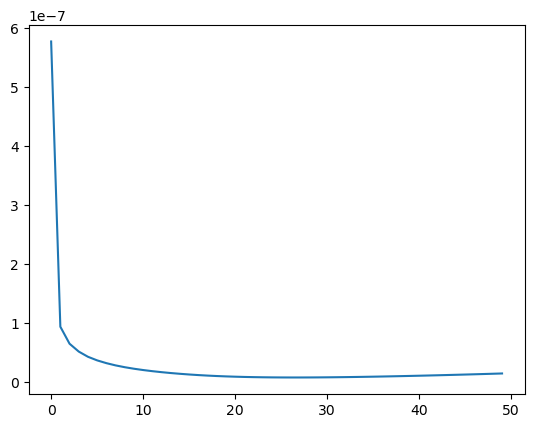

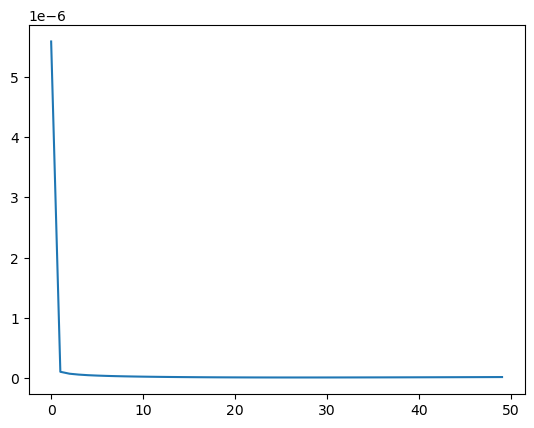

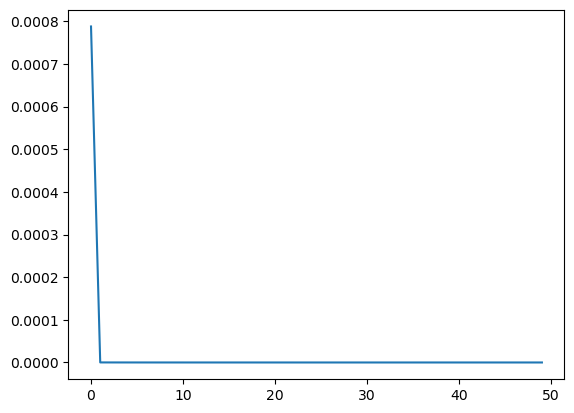

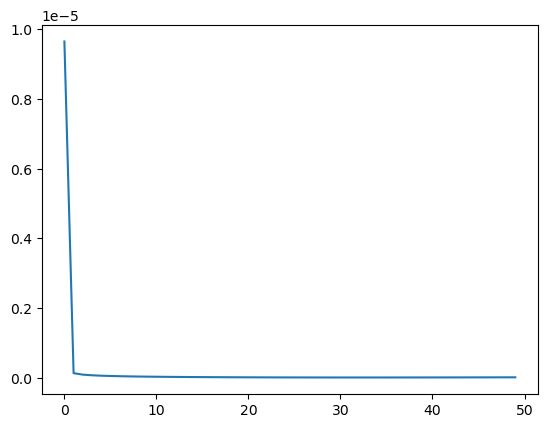

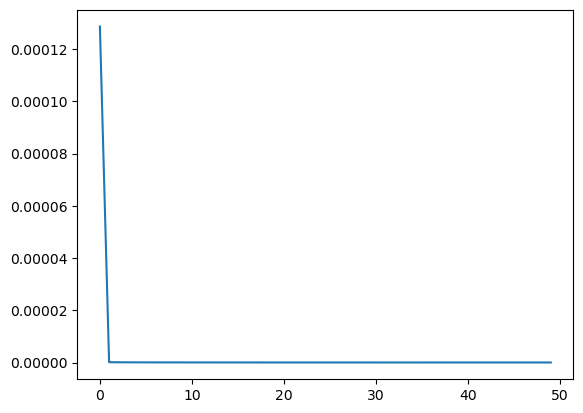

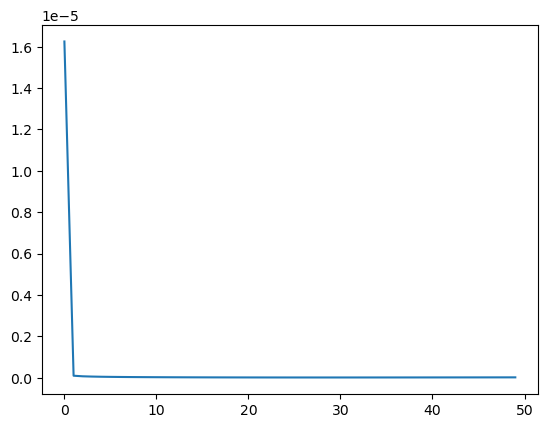

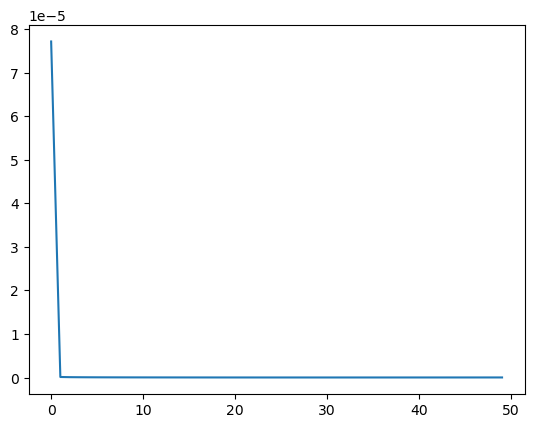

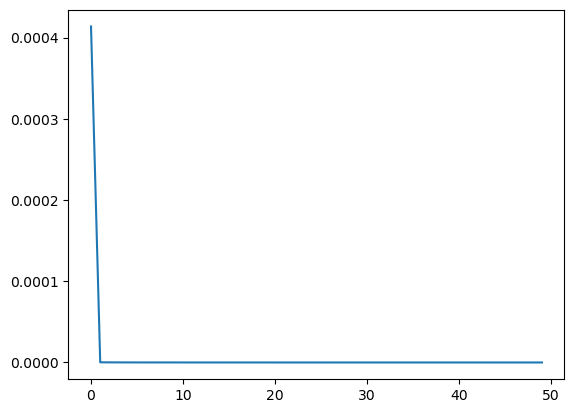

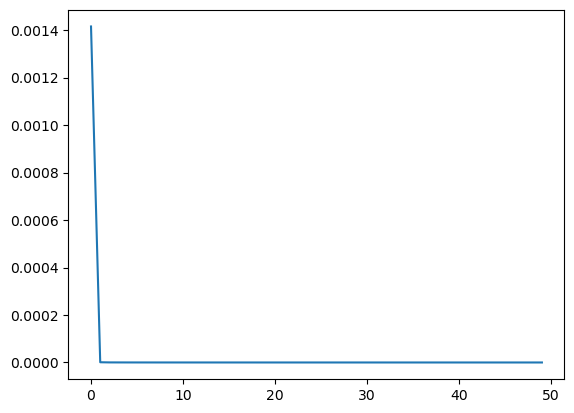

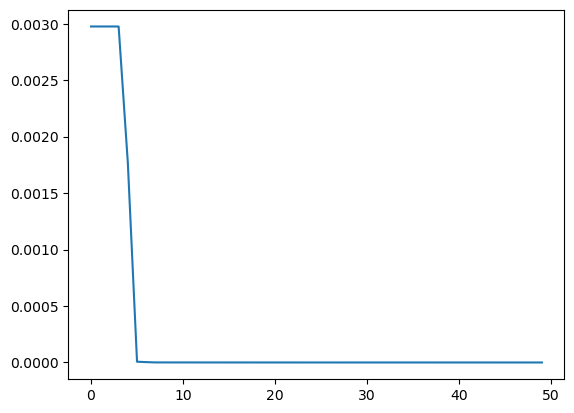

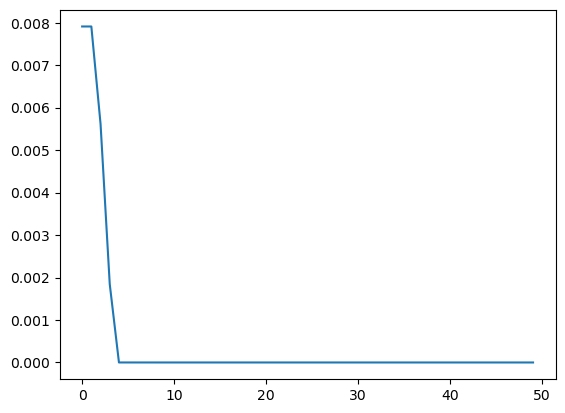

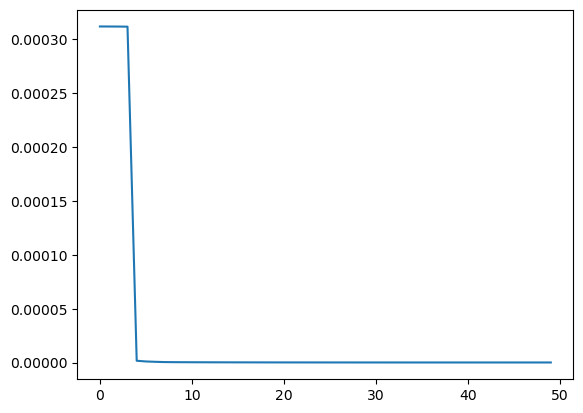

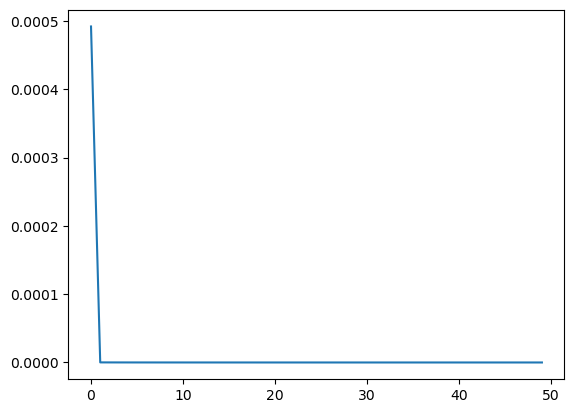

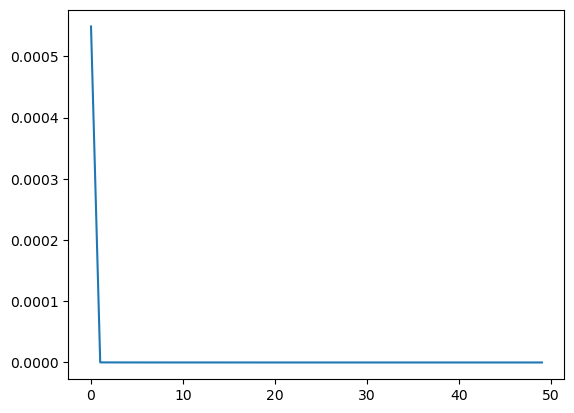

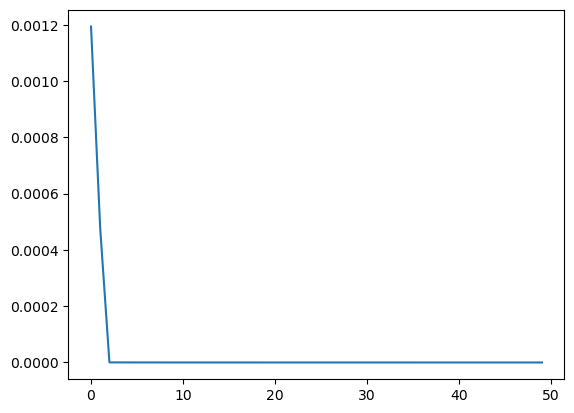

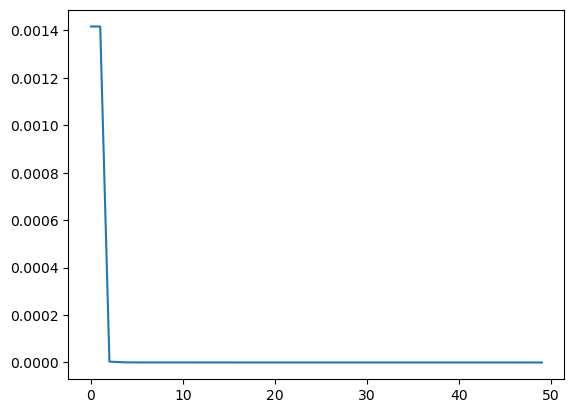

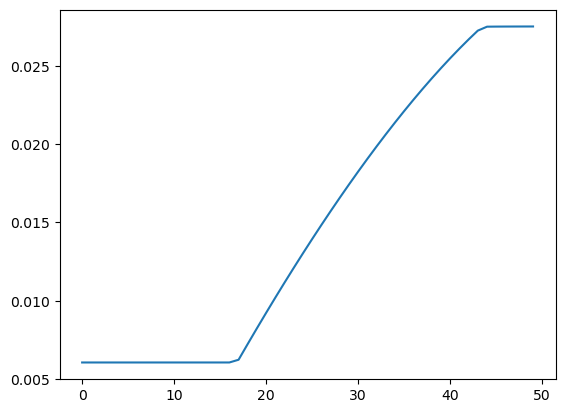

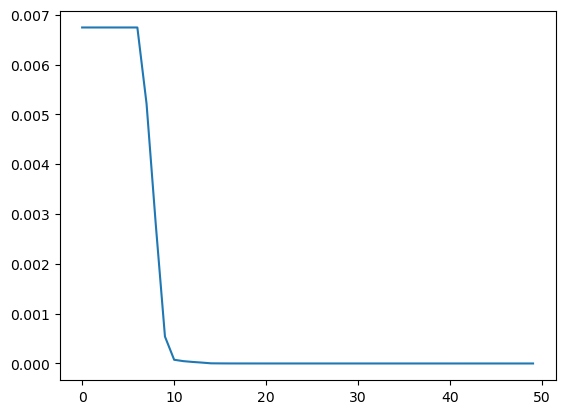

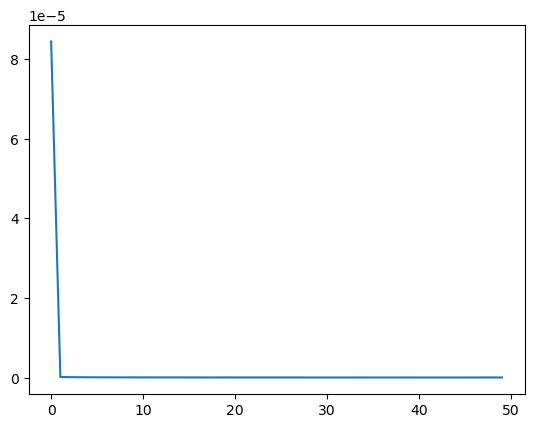

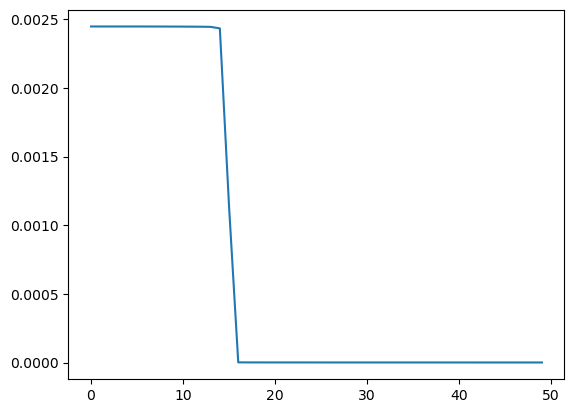

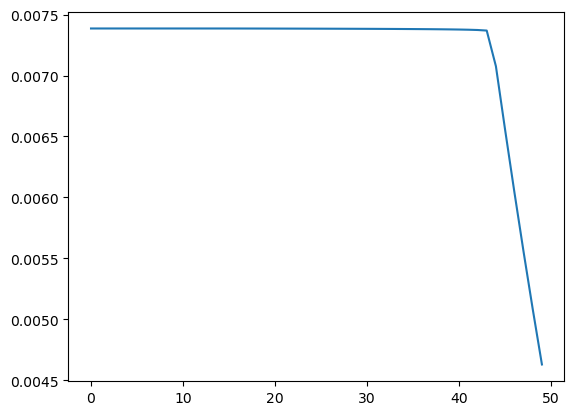

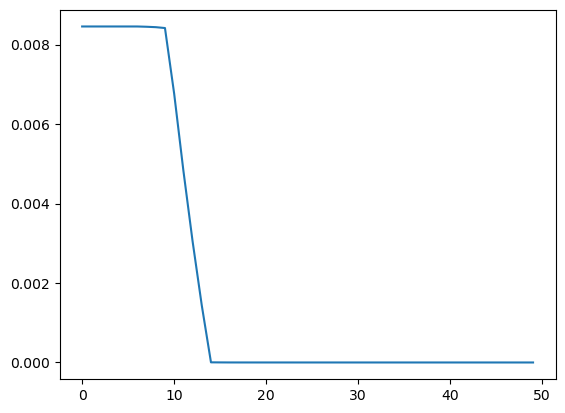

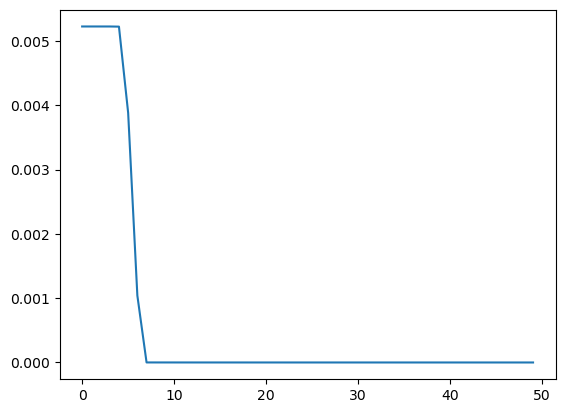

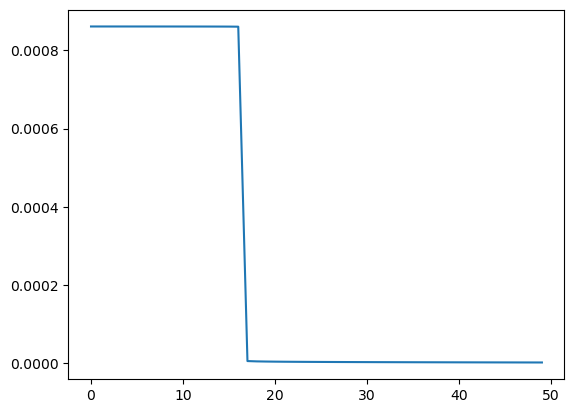

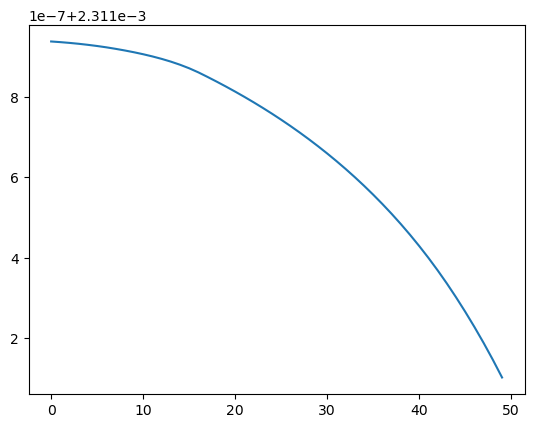

In [77]:
for i in range(n):
    plt.plot(x_gamma[i,0:50])
    plt.show()

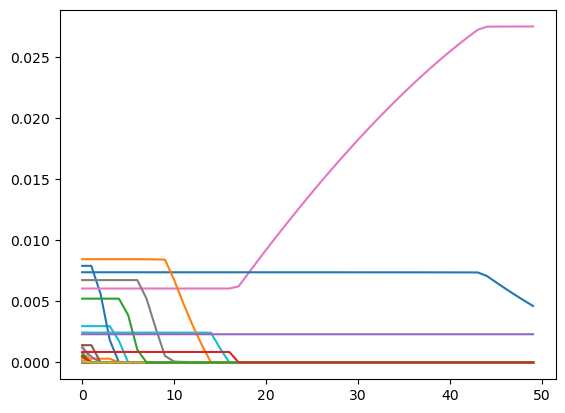

In [78]:
for i in range(n):
    plt.plot(x_gamma[i,0:50])
plt.show()

In [11]:
inputs = [ic,opti.x, opti.lam_g]
outputs = [Up[:,0],Um[:,0],opti.x, opti.lam_g]
current_x = vertcat(Z0_list[0:n],np.sum(X0_list[0:n]),1)

mpc_step = opti.to_function('mpc_step',inputs,outputs)
nn = 50

x_history  = DM.zeros(n+2,nn+1)
u_history  = DM.zeros(n,nn)
um_history = DM.zeros(n,nn)
up_history = DM.zeros(n,nn)

up  = sol.value(Up[:,0]) 
um  = sol.value(Um[:,0])
x   = sol.value(opti.x)
lam = sol.value(opti.lam_g)


x_history[:,0] = current_x
pre_price = p2
t1 = time.time()
for i in range(nn):
    t0 = time.time()
    u_history[:,i]  = up - um
    um_history[:,i] = um
    up_history[:,i] = up
    current_x = f(current_x,um, up)
    [up,um,x,lam] = mpc_step(current_x,x,lam)
    x_history[:,i+1] = current_x
    disp(f'Year: {i+1}, time: {time.time()-t0}')
disp(f'Finale, time: {time.time()-t1}')


Year: 1, time: 1.393894910812378
Year: 2, time: 1.4591102600097656
Year: 3, time: 1.5014500617980957
Year: 4, time: 1.5379199981689453
Year: 5, time: 1.4863290786743164
Year: 6, time: 1.3831050395965576
Year: 7, time: 1.468027114868164
Year: 8, time: 1.8277990818023682
Year: 9, time: 1.7628898620605469
Year: 10, time: 1.470473051071167
Year: 11, time: 1.4287099838256836
Year: 12, time: 1.7237498760223389
Year: 13, time: 1.6419668197631836
Year: 14, time: 1.65364408493042
Year: 15, time: 1.709245204925537
Year: 16, time: 1.808694839477539
Year: 17, time: 1.6676149368286133
Year: 18, time: 1.5204567909240723
Year: 19, time: 1.256669282913208
Year: 20, time: 1.3253579139709473
Year: 21, time: 1.1464300155639648
Year: 22, time: 1.3157610893249512
Year: 23, time: 1.2744381427764893
Year: 24, time: 1.2816991806030273
Year: 25, time: 1.0889737606048584
Year: 26, time: 1.0590317249298096
Year: 27, time: 1.213331937789917
Year: 28, time: 1.2386269569396973
Year: 29, time: 1.1364870071411133
Yea

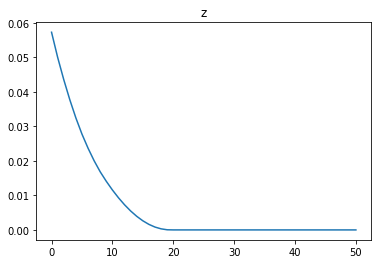

In [16]:
plt.plot(np.sum(x_history[0:n,0:].T, axis=1))
plt.title('z')
plt.show()

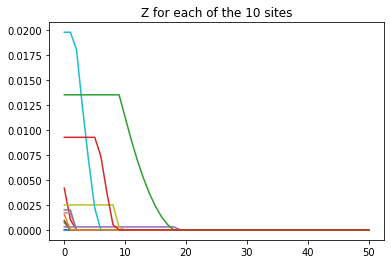

In [17]:
plt.plot(x_history[0:n,0:].T)
plt.title('Z for each of the 10 sites')
plt.show()

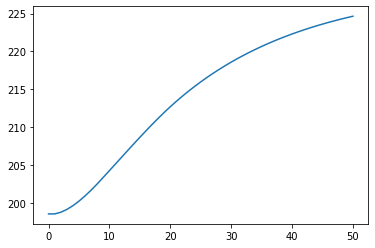

In [13]:
plt.plot(np.sum(x_history[-2,0:].T, axis=1))
plt.show()